# 1. 데이터셋 다운로드

In [1]:
# download dataset by url link
!wget -O dataset.zip https://www.dropbox.com/s/pj6zfdf5f5l6rhe/imitation_22ver.zip?dl=0
# unzip zip file
!unzip -qq dataset.zip
# delete downloaded zip file
!rm -rf dataset.zip
# rename data path
!mv imitation_22ver/ dataset/

# carla 시뮬레이터를 이용한 데이터 수집

--2023-12-09 15:32:08--  https://www.dropbox.com/s/pj6zfdf5f5l6rhe/imitation_22ver.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pj6zfdf5f5l6rhe/imitation_22ver.zip [following]
--2023-12-09 15:32:08--  https://www.dropbox.com/s/raw/pj6zfdf5f5l6rhe/imitation_22ver.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7394db5fd53f79feaecf2bff07.dl.dropboxusercontent.com/cd/0/inline/CJEPilJcslDy6-_aEibx48yHk3K1ybbzrLfQmN48_dVk6tiQz8TUaqQl7r_BawhuKQU9lNWG49F42d2ZMN9mJCXSkSJubQUw-i3N8TY4trfF91JkK5Odfhd_sSWV1hUGtYEL0r7dKrT_5ZtaeIEkBMcu/file# [following]
--2023-12-09 15:32:09--  https://uc7394db5fd53f79feaecf2bff07.dl.dropboxusercontent.com/cd/0/inline/CJEPilJcslDy6-_aEibx48yHk3K1ybbzrLfQmN48_dVk6tiQz8TUaqQl7r_BawhuKQU9lNWG4

# 2. EDA (Exploratory Data Analysis)

In [2]:
# 데이터 기본 디렉토리 지정
import os
data_dir = os.path.join(os.getcwd(), 'dataset')
print(os.listdir(data_dir))

['label.csv', '.DS_Store', 'images']


In [3]:
# label.csv 파일 탐색
label_path = os.path.join(data_dir, 'label.csv')

import pandas as pd
label_df = pd.read_csv(label_path)
label_df

,img,steer
0,329571.jpg,0.019361
1,329580.jpg,0.090791
2,329590.jpg,0.090791
3,329603.jpg,-0.007297
4,329610.jpg,-0.056953
...,...,...
1647,411920.jpg,0.001657
1648,411930.jpg,0.024448
1649,411940.jpg,0.027501
1650,411950.jpg,0.036455


count    1652.000000
mean       -0.048909
std         0.130272
min        -0.500000
25%        -0.111353
50%        -0.013198
75%         0.021193
max         0.500000
Name: steer, dtype: float64


<Axes: >

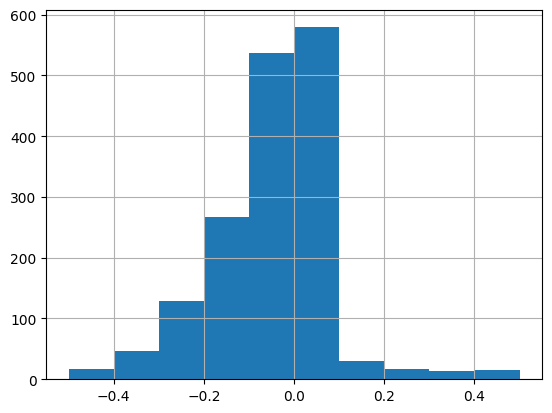

In [4]:
# steer 값 탐색
print(label_df['steer'].describe())

label_df['steer'].hist()
# 정답값들이 0보다 왼쪽에 약간 치우쳐있는 분포이다

Index:  726
Image name:  336830.jpg
Steer:  -0.0162507801636829
Image shape:  (256, 512, 3)


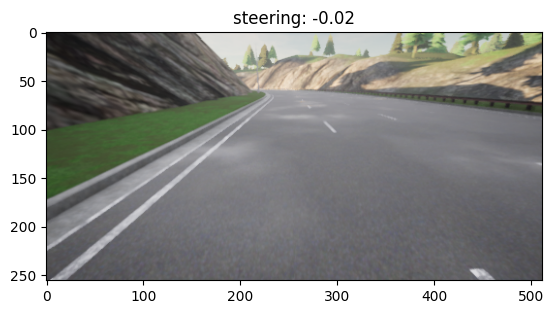

In [5]:
# X,Y 데이터 시각화 확인

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def load_image(img_name):
    # https://m.blog.naver.com/nostresss12/221950215408

    path_img = os.path.join(data_dir, 'images', img_name)
    img_data = Image.open(path_img).convert('RGB')

    return img_data


def visualize_data(img_name, label):

    img = load_image(img_name)
    print("Image shape: ", np.array(img).shape)

    plt.imshow(img)
    plt.title("steering: {:.2f}".format(label))
    plt.show()


i = np.random.choice(label_df.index)
img_name = label_df['img'][i]
label = label_df[label_df['img'] == img_name]['steer'].values[0]
print("Index: ", i)
print("Image name: ", img_name)
print("Steer: ", label)

visualize_data(img_name, label)
# 차량이 바라보고 있는 이미지와 조향각이 나오고 있다.
# 도로의 끝을 바라보면 길이 왼쪽을 향하고 있는데 이에 맞춰 조향각또한 -0.02가 나오고 있다.

# 3. 딥러닝 모델 생성

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def get_model():

    model = Sequential()

    # ▼▼▼▼ Nvidia의 End-to-End 모델 구현 ▼▼▼▼
    # input data shape: (None, 256, 512, 3)
    # output data shape: (None, 1)

    # 컨볼루션 레이어 : 24채널 / 5*5 윈도우 사이즈
    # 패딩 : valid -> 즉, 적용하지 않음
    # 활성함수 : ReLU 적용 / gradient vanishing 문제 해결
    # 입력 이미지 : (256, 512) 사이즈의 3채널 이미지
    # 풀링 : MaxPooling(2,2) 적용
    model.add(Conv2D(24, 5, padding ='valid', activation='relu', input_shape =(256,512,3)))
    model.add(MaxPooling2D(2,2, padding = 'valid'))

    # 컨볼루션 레이어 : 36채널 / 5*5 윈도우 사이즈
    # 패딩 : valid -> 즉, 적용하지 않음
    # 활성함수 : ReLU 적용 / gradient vanishing 문제 해결
    # 풀링 : MaxPooling(2,2) 적용
    model.add(Conv2D(36, 5, padding ='valid', activation='relu'))
    model.add(MaxPooling2D(2,2, padding = 'valid'))


    # 컨볼루션 레이어 : 48채널 / 5*5 윈도우 사이즈
    # 패딩 : valid -> 즉, 적용하지 않음
    # 활성함수 : ReLU 적용 / gradient vanishing 문제 해결
    # 풀링 : MaxPooling(2,2) 적용
    model.add(Conv2D(48, 5, padding ='valid', activation='relu'))
    model.add(MaxPooling2D(2,2, padding = 'valid'))


    # 컨볼루션 레이어 : 64채널 / 3*3 윈도우 사이즈
    # 패딩 : valid -> 즉, 적용하지 않음
    # 활성함수 : ReLU 적용 / gradient vanishing 문제 해결
    # 풀링 : MaxPooling(2,2) 적용
    model.add(Conv2D(64, 3, padding ='valid', activation='relu'))
    model.add(MaxPooling2D(2,2, padding = 'valid'))


    # 컨볼루션 레이어 : 64채널 / 3*3 윈도우 사이즈
    # 패딩 : valid -> 즉, 적용하지 않음
    # 활성함수 : ReLU 적용 / gradient vanishing 문제 해결
    # 풀링 : MaxPooling(2,2) 적용
    model.add(Conv2D(64, 3, padding ='valid', activation='relu'))
    model.add(MaxPooling2D(2,2, padding = 'valid'))


    # Flatten 적용
    model.add(Flatten())

    # 완전연결 레이어 : 100개, 50개, 10개
    # 활성함수 : ReLU 적용
    # 배치 정규화 : 안정적 학습 진행, 초기화에 대한 의존성 감소
    # 드롭아웃 : 완전연결망의 많은 연산량을 줄이기 위한 장치로 사용, 일반화 성능을 높이기 위함
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))

    # 최종 출력 레이어
    model.add(Dense(1))
    # 하나의 조향각을 예측하는 출력 , 데이터의 특성 상 활성함수 따로 적용하지 않아도 됨

    # ▲▲▲▲ Nvidia의 End-to-End 모델 구현 ▲▲▲▲

    return model

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 252, 508, 24)      1824      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 126, 254, 24)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 250, 36)      21636     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 61, 125, 36)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 57, 121, 48)       43248     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 28, 60, 48)       

# 4. 학습 및 검증 데이터 분할

In [25]:
# Set the number of training and validation data
VAL_RATIO = 0.2

len_val = int(np.ceil(len(label_df) * VAL_RATIO))
len_train = int(len(label_df) - len_val)

print(len(label_df), len_train, len_val)

def split_train_val(df, val_ratio):
    '''입력받은 데이터프레임를 ratio 기준으로
    학습용 데이터프레임과 검증용 데이터프레임으로 분할
    입력 df: 데이터프레임
    입력 val_ratio: 검증데이터 비율
    출력 train_df: 학습용 데이터프레임
    출력 val_df: 검증용 데이터프레임'''

    # ▼▼▼▼ split_train_val 함수 구현을 위한 코드 작성 ▼▼▼▼

    val_indices = np.random.choice(df.index, len_val, replace=False)

    df_val = df.iloc[val_indices].reset_index(drop=True)
    df_train = df.drop(sorted(val_indices), axis=0).reset_index(drop=True)

    # ▲▲▲▲ split_train_val 함수 구현을 위한 코드 작성 ▲▲▲▲

    return df_train, df_val

label_train, label_val = split_train_val(label_df, VAL_RATIO)
print(len(label_df), len(label_train), len(label_val))

1652 1321 331
1652 1321 331


In [26]:
# Duplication Check
for i in range(len(label_train)):
    for j in range(len(label_val)):
        if label_train.loc[i, 'img'] == label_val.loc[j, 'img']:
            print("{}th of train-set and {}th of validation-set are the same data.".format(i, j))
            print("Deduplication is needed")
            break

# 5. 데이터로더 생성

In [27]:
from tensorflow.keras.utils import Sequence
import math

# https://minimin2.tistory.com/100
class DataLoader(Sequence):
    def __init__(self, label_df, batch_size, shuffle=False):
        self.label_df = label_df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.x_min = -0.5 # min 값 설정
        self.x_max = 0.5 # max 값 설정

    def on_epoch_end(self):
        self.indices = np.arange(len(self.label_df))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(len(self.label_df) / self.batch_size)

    def __getitem__(self, idx):

        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.label_df.iloc[i, 0] for i in indices]
        batch_y = [self.label_df.iloc[i, 1] for i in indices]

        # ▼▼▼▼ batch_x 변수에 이미지 데이터 로드 ▼▼▼▼
        # np.array(batch_x).shape = (batch_size, 256, 512, 3)

        batch_x = [np.array(load_image(image_name))/255.0 for image_name in batch_x]

        # ▲▲▲▲ batch_x 변수에 이미지 데이터 로드 ▲▲▲▲


        # ▼▼▼▼ batch_y Min-Max Normalization ▼▼▼▼

        batch_y = [self.min_max_normalize(y) for y in batch_y]

        # ▲▲▲▲ batch_y Min-Max Normalization ▲▲▲▲

        return np.array(batch_x), np.array(batch_y)

    def min_max_normalize(self, x):

        x_scaled = ( x - self.x_min / self.x_max - self.x_min) # min-max 정규화 수식 적용

        return x_scaled

In [28]:
total_data_loader = DataLoader(label_df = label_df, batch_size = 1, shuffle = False)
x, y = total_data_loader[0]
print(x.shape)
print(y.shape)

(1, 256, 512, 3)
(1,)


In [31]:
# 학습 및 검증 데이터로더 생성
batch_size = 16 # 배치사이즈 설정
train_data_loader = DataLoader(label_df = label_train,
                               batch_size = batch_size,
                               shuffle = True)

val_data_loader = DataLoader(label_df = label_val,
                             batch_size = batch_size,
                             shuffle = True)

# 6. 학습 설정

In [32]:
LOSS = 'mse' # mse 가 이상치 즉 튀는 값을 잡아주는 역할을 해줍니다.
OPTIMIZER = 'adam' # 옵티마이저 Adam 적용
METRIC = 'mae' # 전체적인 부분을 파악할 수 있도록 mae 사용합니다

model.compile(loss = LOSS,
              optimizer = OPTIMIZER,
              metrics = [METRIC])

# 7. 모델 학습

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10

# 학습 종료 시점에 대한 고찰
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

history = model.fit(x = train_data_loader,
                    validation_data = val_data_loader,
                    epochs = epochs)

Epoch 1/10
83/83 [==============================] - 25s 260ms/step - loss: 0.7918 - mae: 0.6907 - val_loss: 1.2254 - val_mae: 1.0131
Epoch 2/10
83/83 [==============================] - 21s 249ms/step - loss: 0.2925 - mae: 0.4269 - val_loss: 0.7547 - val_mae: 0.6958
Epoch 3/10
83/83 [==============================] - 20s 237ms/step - loss: 0.2302 - mae: 0.3708 - val_loss: 0.1816 - val_mae: 0.3600
Epoch 4/10
83/83 [==============================] - 21s 246ms/step - loss: 0.1726 - mae: 0.3273 - val_loss: 0.3091 - val_mae: 0.4722
Epoch 5/10
83/83 [==============================] - 20s 243ms/step - loss: 0.1309 - mae: 0.2803 - val_loss: 0.0679 - val_mae: 0.2041
Epoch 6/10
83/83 [==============================] - 21s 252ms/step - loss: 0.1136 - mae: 0.2635 - val_loss: 0.0726 - val_mae: 0.2047
Epoch 7/10
83/83 [==============================] - 20s 243ms/step - loss: 0.0935 - mae: 0.2420 - val_loss: 0.0426 - val_mae: 0.1582
Epoch 8/10
83/83 [==============================] - 21s 253ms/step - 

# 8. 학습이 완료된 모델 저장

In [34]:
model.save('my_model')
!zip -r my_model.zip my_model/*

  adding: my_model/assets/ (stored 0%)
  adding: my_model/fingerprint.pb (stored 0%)
  adding: my_model/keras_metadata.pb (deflated 94%)
  adding: my_model/saved_model.pb (deflated 88%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 68%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 27%)


# 9. 제출 전 저장된 모델이 정상적으로 로드되는지 확인!

In [35]:
from tensorflow.keras.models import load_model

!unzip my_model.zip -d check/

loaded_model = load_model('check/my_model')
print(loaded_model.summary())

loaded_model.evaluate(x = val_data_loader)

Archive:  my_model.zip
   creating: check/my_model/assets/
 extracting: check/my_model/fingerprint.pb  
  inflating: check/my_model/keras_metadata.pb  
  inflating: check/my_model/saved_model.pb  
   creating: check/my_model/variables/
  inflating: check/my_model/variables/variables.index  
  inflating: check/my_model/variables/variables.data-00000-of-00001  
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 252, 508, 24)      1824      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 126, 254, 24)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 250, 36)      21636     
                                                                 
 max_pooling2d_11 (Max

[0.040615785866975784, 0.14684902131557465]

# 10. 정상적으로 저장되었다면 `my_model.zip` 파일을 `학번_이름_과제2.zip`으로 변경해서 제출하시오.